# 7. Averaging Model Approach

## 7.1 Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
import joblib
import pickle
import warnings
warnings.filterwarnings("ignore")

## 7.2 Data Loading and Preprocessing

In [2]:
train = pd.read_csv('train.csv')
print(f"total train datapoints = {len(train)}") 
test = pd.read_csv('test.csv')
print(f"total test datapoints = {len(test)}")

total train datapoints = 4209
total test datapoints = 4209


**Using LabelEncoder() for encoding categorical features.**

In [3]:
def preprocess_categorical(data, IDs):
    """
    data : pandas dataframe
    IDs: ID feature
    return: dataframe, labels
    
    This function takes the dataframe as input, 
    encodes the 
    categorical features.
    """
    # create empty lists for collecting feature names
    cat_features = []
    Binary_features = []
    
    # Collect the categorical and binary feature names 
    for f in data.columns:
        if data[f].dtype == 'object':
            cat_features.append(f)
        elif data[f].dtype == 'int' and f != 'ID':
            Binary_features.append(f)
        
    # create categorical feature dataframe
    cat_df = data[cat_features]
    # create binary feature dataframe
    bin_df = data[Binary_features]
    bin_df.insert(0, 'ID', IDs.values)
    
    # Now encode each categorical feature
    for feature in cat_features:
        encoder = LabelEncoder()
        cat_df[feature] = encoder.fit_transform(cat_df[feature].values)
        filename = f'{feature}encoder.sav'
        joblib.dump(encoder, filename)
    cat_df = pd.DataFrame(cat_df, columns = cat_features)
    cat_df.insert(0, 'ID', IDs.values)
    # Merge binary and categorical dataframes together
    new_data = pd.merge(cat_df, bin_df, on='ID', how='left')
    # return dataframe and labels
    if 'y' in data.columns:
        labels = data['y']
        return new_data, labels
    else:
        return new_data

In [4]:
final_train = train.copy()

train_ID = train['ID'].copy()

print(f"{final_train.shape}")

(4209, 378)


In [5]:
final_test = test.copy()

test_ID = test['ID'].copy()

print(f"{final_test.shape}")

(4209, 377)


In [6]:
X_train, y_train = preprocess_categorical(final_train, train_ID)
X_test = preprocess_categorical(final_test, test_ID)

print("Train set:")
print(X_train.shape)
print(y_train.shape)
print("Test set:")
print(X_test.shape)

Train set:
(4209, 377)
(4209,)
Test set:
(4209, 377)


## 7.3 New Averaging Model

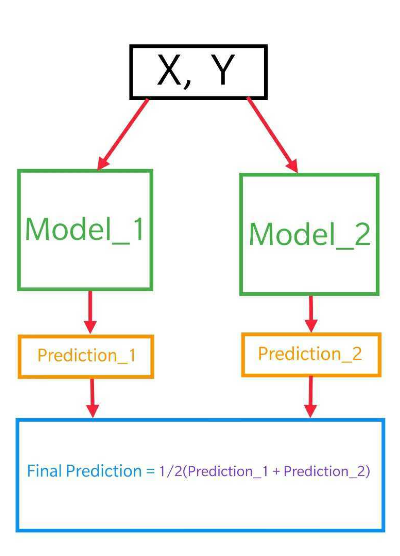

- Steps:
1. Create and train model 1 : Xgboost
2. Create and train model 2 : Xgboost
3. Predict values by using trained model 1
4. Predict values by using trained model 2
5. Get average of the values predicted by two models

In [7]:
def averaged_model(X_train,y_train,X_test):
    """
    X_train : train features data
    y_train : train labels
    X_test : test features data
    """
    
    # get the mean target value
    y_mean = np.mean(y_train)
    # set the seed for reproducing results
    np.random.seed(2)
    # create xgboost model 1 and train it on X_train, y_train
    model_1 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=10.0, reg_lambda=1, scale_pos_weight=1, subsample=0.93,
             tree_method='exact', validate_parameters=1, verbosity=None)
    
    print("Fitting first model...")
    model_1.fit(X_train, y_train)
    # predict target values for train data
    y_tr_pred1 = model_1.predict(X_train)
    # predict target values for test data
    p1 = model_1.predict(X_test)
    # save the model to the disk for future use
    filename = "final_best_model1.pkl"
    model_2 = joblib.dump(model_1, filename)
    print(f'Saved {filename}')
    print("Done.")
    
    # create parameters list for second xgboost model
    xgb_params = {'eta': 0.0045,
                    'max_depth': 4,
                    'subsample': 0.93,
                    'eval_metric': 'rmse',
                    'base_score': y_mean, # base prediction = mean(target)
                    'colsample_bytree': 0.7,
                    'seed': 2}
    num_boost_rounds = 1250
    
    # create xgb ready data 
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)
    
    # train xgb model 2 
    print("Fitting second model...")
    model_2 = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
    # predict target values for train data
    y_tr_pred2 = model_2.predict(dtrain)
    # predict target values for test data
    p2 = model_2.predict(dtest)
    # save the model to the disk for future use
    filename = "final_best_model2.pkl"
    model_2 = joblib.dump(model_2, filename)
    print(f'Saved {filename}')
    print("Done.")
    
    # average the predictions for train data by both models and calculate the r2_score
    avg_pred = (y_tr_pred1+y_tr_pred2)/2
    print(r2_score(y_train, avg_pred))
    
    # average the predictions for test data by model 1 and model 2
    final_pred = (p1+p2)/2
    
    # create pandas series for storing predictions
    pred_test = pd.Series()
    pred_test['y'] = final_pred
    # return the final averaged predictions
    return pred_test['y']

In [8]:
final_preds = averaged_model(X_train,y_train,X_test)

Fitting first model...
Saved final_best_model1.pkl
Done.
Fitting second model...
Saved final_best_model2.pkl
Done.
0.6142291416276575


In [9]:
submission_Stack = pd.read_csv('sample_submission.csv')
submission_Stack['y'] = final_preds
submission_Stack.to_csv('final-averaged-xgb.csv', index=False)
submission_Stack.head()

,ID,y
0,1,81.276283
1,2,99.784988
2,3,81.343719
3,4,79.509239
4,5,114.750397


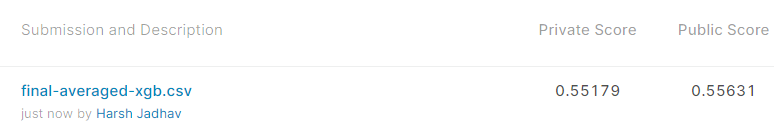

- Train R2 = 0.6142291
- Test Private R2 = 0.55179
- Test Public R2 = 0.55631

# 8. Model Comparison

In [10]:
from prettytable import PrettyTable
# Add Columns
comparison = PrettyTable(["Sr.No.", "Model", "Train", "Kaggle Private", "Kaggle Public"]) 

# Add rows 
comparison.add_row([1,"Knn+Original", "0.58172", "0.43537", "0.4636"]) 
comparison.add_row([2,"DecisionTree+Original", "0.63128", "0.53732", "0.55129"]) 
comparison.add_row([3,"DecisionTree+Original+PCA+SVD", "0.61559", "0.53800", "0.55070"]) 
comparison.add_row([4,"RandomForest+Original", "0.62903", "0.54763", "0.55442"]) 
comparison.add_row([5,"RandomForest+Original+PCA+SVD", "0.63649", "0.54145", "0.55076"]) 
comparison.add_row([6,"RandomForest+Original+PCA+SVD\n+GRP+Interactions", "0.65277", "0.54920", 
                    "0.54220"])
comparison.add_row([7,"Xgboost+Original+PCA+SVD+GRP\n+Interactions", "0.65518", "0.54682", 
                    "0.54759"]) 
comparison.add_row([8,"Stacked+Original+PCA+SVD+GRP\n+Interactions", "0.65300", "0.55017", 
                    "0.55310"]) 
comparison.add_row([9,"Custom+Original+PCA+SVD+GRP\n+Interactions", "0.279103", "-", "-"]) 
comparison.add_row([10,"Averaged-xgb+Original","0.614229", "0.55179", "0.55631"]) 

print(comparison)

+--------+-------------------------------+----------+----------------+---------------+
| Sr.No. |             Model             |  Train   | Kaggle Private | Kaggle Public |
+--------+-------------------------------+----------+----------------+---------------+
|   1    |          Knn+Original         | 0.58172  |    0.43537     |     0.4636    |
|   2    |     DecisionTree+Original     | 0.63128  |    0.53732     |    0.55129    |
|   3    | DecisionTree+Original+PCA+SVD | 0.61559  |    0.53800     |    0.55070    |
|   4    |     RandomForest+Original     | 0.62903  |    0.54763     |    0.55442    |
|   5    | RandomForest+Original+PCA+SVD | 0.63649  |    0.54145     |    0.55076    |
|   6    | RandomForest+Original+PCA+SVD | 0.65277  |    0.54920     |    0.54220    |
|        |       +GRP+Interactions       |          |                |               |
|   7    |  Xgboost+Original+PCA+SVD+GRP | 0.65518  |    0.54682     |    0.54759    |
|        |         +Interactions         | 

# 8. Conclusion

- Averaged model with Original features is performing better than any other models, with score of 0.55179 on private leaderboard and achieves 401th position.

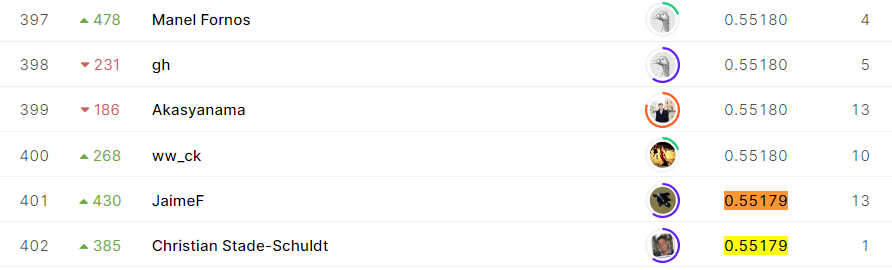